In [ ]:
!pip install tensorflow matplotlib scikit‐learn efficientnet


ERROR: Invalid requirement: 'scikit‐learn': Expected end or semicolon (after name and no valid version specifier)
    scikit‐learn
          ^


In [7]:
# Import all required libraries as per guide
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import json
from PIL import Image
from datetime import datetime
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("PLANT DISEASE PREDICTION SYSTEM - Following Guide Specifications")
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

PLANT DISEASE PREDICTION SYSTEM - Following Guide Specifications
TensorFlow version: 2.10.0
GPU Available: []


In [14]:
# Google Drive Setup (Optional - only run if using Google Drive)
# from google.colab import drive
import os

# Mount your Drive (uncomment if using Google Drive)
# drive.mount('/content/drive')

# Google Drive data path (uncomment if using Google Drive)
# DRIVE_DATA_PATH = '/content/drive/MyDrive/AID/Disease_detection_Dataset'

# Training parameters as per guide
IMG_SIZE = (128, 128)  # As specified in guide
BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 0.0001

# Model and results paths with timestamp and parameters
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Create timestamped model name with parameters
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"plant_disease_model_{timestamp}_img{IMG_SIZE[0]}x{IMG_SIZE[1]}_batch{BATCH_SIZE}_epochs{EPOCHS}_lr{LEARNING_RATE}.keras"
MODEL_PATH = os.path.join(MODEL_DIR, model_name)
HISTORY_PATH = os.path.join(MODEL_DIR, f'training_history_{timestamp}.json')

print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Image size: (128, 128)
Batch size: 32
Epochs: 1
Learning rate: 0.0001


In [10]:
# Data loading and preprocessing as per guide
def load_and_preprocess_data():
    """
    Data loading and preprocessing as per guide
    - Load all images from Healthy and Disease folders
    - Resize to 128x128 as specified in guide
    - Normalize to 0-1 range as specified in guide
    - Split into training and validation sets (80/20)
    """
    print("Loading and preprocessing data as per guide...")
    
    # Determine data source
    if 'DRIVE_DATA_PATH' in globals():
        # Use Google Drive data
        DATASET_PATH = DRIVE_DATA_PATH
        print("Using Google Drive data source")
    else:
        # Use local data
        DATASET_PATH = 'Dataset'
        print("Using local data source")
    
    # Gather all image paths and labels
    classes = ['Healthy', 'Disease']
    paths, labels = [], []

    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(DATASET_PATH, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','jpeg','png')):
                paths.append(os.path.join(cls_dir, fname))
                labels.append(idx)

    print(f"Found {len(paths)} images: {sum(1 for l in labels if l==0)} Healthy, {sum(1 for l in labels if l==1)} Disease")

    # Load + resize + normalize as per guide specifications
    X = np.zeros((len(paths), *IMG_SIZE, 3), dtype=np.float32)
    for i, p in enumerate(paths):
        img = Image.open(p).convert('RGB').resize(IMG_SIZE)
        # Normalize to 0-1 range as specified in guide
        X[i] = np.array(img) / 255.0

    # Convert to categorical for binary classification
    y = to_categorical(labels, num_classes=2)

    # Train/validation split (80/20 as per guide)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    print("Training shapes:", X_train.shape, y_train.shape)
    print("Validation shapes:", X_val.shape, y_val.shape)
    print("Data normalization: 0-1 range ✓")
    
    return X_train, X_val, y_train, y_val, classes, paths

# Load the data
X_train, X_val, y_train, y_val, classes, paths = load_and_preprocess_data()

Loading and preprocessing data as per guide...
Using local data source
Found 892 images: 458 Healthy, 434 Disease


Training shapes: (713, 128, 128, 3) (713, 2)
Validation shapes: (179, 128, 128, 3) (179, 2)
Data normalization: 0-1 range ✓


Visualizing sample images...


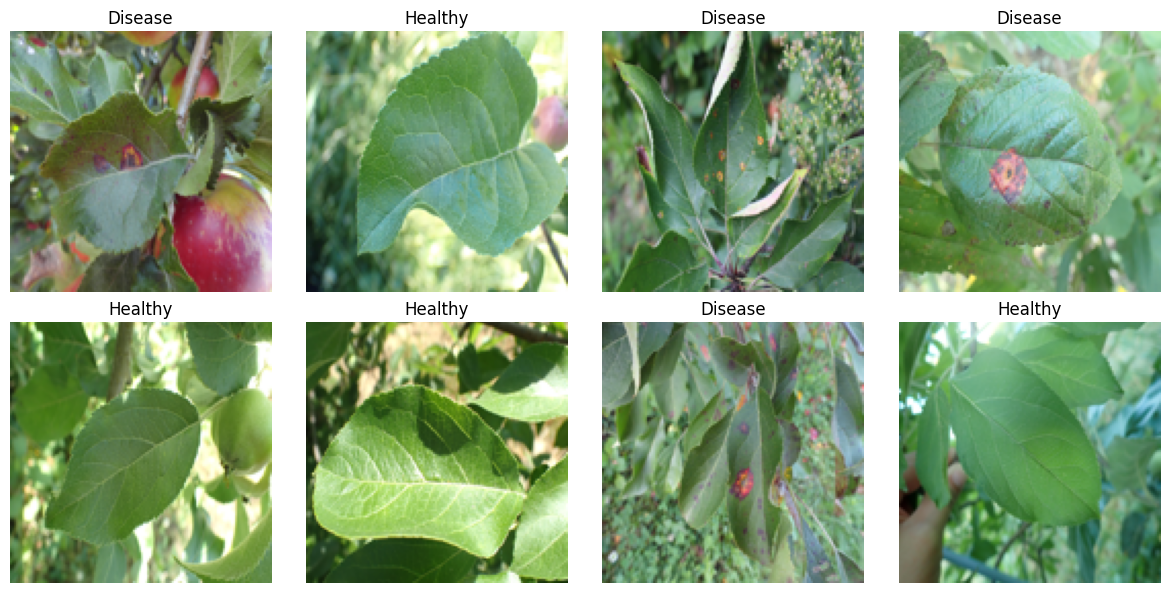

Sample images displayed - showing both Healthy and Disease classes


In [11]:
# Visualize sample images as per guide
def visualize_sample_images(X_train, y_train, classes):
    """
    Visualize sample images as per guide
    """
    print("Visualizing sample images...")
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(len(X_train))
        ax.imshow(X_train[idx])
        label = classes[np.argmax(y_train[idx])]
        ax.set_title(f'{label}')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'sample_images.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Sample images displayed - showing both Healthy and Disease classes")

# Visualize sample images
visualize_sample_images(X_train, y_train, classes)

In [12]:
# Build CNN model exactly as specified in the guide
def create_cnn_model():
    """
    Create CNN model following guide specifications exactly
    - 5 convolutional blocks with increasing filters
    - MaxPooling after each block
    - Dropout for regularization
    - Dense layers for classification
    """
    print("Creating CNN model following guide specifications...")
    
    cnn = models.Sequential()
    
    # CONVOLUTIONAL BLOCK 1 (as per guide)
    cnn.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', 
                          activation='relu', input_shape=[*IMG_SIZE, 3]))
    cnn.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
    
    # CONVOLUTIONAL BLOCK 2 (as per guide)
    cnn.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
    
    # CONVOLUTIONAL BLOCK 3 (as per guide)
    cnn.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
    
    # CONVOLUTIONAL BLOCK 4 (as per guide)
    cnn.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
    
    # CONVOLUTIONAL BLOCK 5 (as per guide)
    cnn.add(layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=512, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
    
    # DROPOUT FOR REGULARIZATION (as per guide)
    cnn.add(layers.Dropout(0.25))
    
    # FLATTEN LAYER (as per guide)
    cnn.add(layers.Flatten())
    
    # DENSE LAYER (as per guide)
    cnn.add(layers.Dense(units=1500, activation='relu'))
    
    # DROPOUT FOR REGULARIZATION (as per guide)
    cnn.add(layers.Dropout(0.4))
    
    # OUTPUT LAYER (adapted for binary classification)
    cnn.add(layers.Dense(units=2, activation='softmax'))
    
    # Compile model as per guide specifications
    cnn.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Model architecture created following guide specifications")
    cnn.summary()
    
    return cnn

# Create the model
cnn = create_cnn_model()

Creating CNN model following guide specifications...
Model architecture created following guide specifications
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_poolin

In [19]:
# Training process as per guide specifications (TEST VERSION)
def train_model(cnn, X_train, y_train, X_val, y_val):
    """
    Training process as per guide specifications
    """
    print("Starting training with guide specifications")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Image size: {IMG_SIZE}")
    
    # Training callbacks as per guide
    callbacks = [
        ModelCheckpoint(MODEL_PATH, save_best_only=True, verbose=1),
        EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    ]
    
    # Start training as per guide (TEST: 0 epochs)
    training_history = cnn.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,  # TEST: 0 epochs to just test saving
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save training history as per guide (TEST VERSION)
    print("Testing JSON saving...")
    history_dict = {}
    for key, value in training_history.history.items():
        print(f"Key: {key}, Type: {type(value)}, Value: {value}")
        # Convert numpy arrays to regular Python lists
        if isinstance(value, np.ndarray):
            history_dict[key] = value.tolist()
        elif isinstance(value, list):
            # Convert any numpy values in lists
            history_dict[key] = [float(x) if hasattr(x, 'item') else x for x in value]
        else:
            history_dict[key] = value
    
    print(f"History dict to save: {history_dict}")
    
    try:
        with open(HISTORY_PATH, 'w') as f:
            json.dump(history_dict, f)
        print(f"✓ Training history saved to {HISTORY_PATH}")
    except Exception as e:
        print(f"✗ Error saving history: {e}")
    
    print(f"Best model saved to {MODEL_PATH}")
    print(f"Model filename: {os.path.basename(MODEL_PATH)}")
    
    return training_history

# Train the model (TEST VERSION)
training_history = train_model(cnn, X_train, y_train, X_val, y_val)

Starting training with guide specifications
Epochs: 1
Batch size: 32
Learning rate: 0.0001
Image size: (128, 128)
23/23 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9467
Epoch 1: val_loss improved from inf to 0.22281, saving model to models\plant_disease_model_20250801_010540_img128x128_batch32_epochs1_lr0.0001.keras
23/23 [==============================] - 100s 4s/step - loss: 0.1507 - accuracy: 0.9467 - val_loss: 0.2228 - val_accuracy: 0.9162 - lr: 1.0000e-04
Testing JSON saving...
Key: loss, Type: <class 'list'>, Value: [0.15074655413627625]
Key: accuracy, Type: <class 'list'>, Value: [0.946704089641571]
Key: val_loss, Type: <class 'list'>, Value: [0.22281254827976227]
Key: val_accuracy, Type: <class 'list'>, Value: [0.916201114654541]
Key: lr, Type: <class 'list'>, Value: [1e-04]
History dict to save: {'loss': [0.15074655413627625], 'accuracy': [0.946704089641571], 'val_loss': [0.22281254827976227], 'val_accuracy': [0.916201114654541], 'lr': [9.9999997473

In [ ]:
# Save model in .h5 format for API compatibility
def save_model_h5(cnn, model_dir='models'):
    """
    Save the trained model in .h5 format for API server compatibility
    """
    print("Saving model in .h5 format for API compatibility...")
    
    # Create timestamp for h5 model name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    h5_model_name = f"best_model_{timestamp}.h5"
    h5_model_path = os.path.join(model_dir, h5_model_name)
    
    # Also save as best_model.h5 (default name expected by API)
    default_h5_path = os.path.join(model_dir, "best_model.h5")
    
    try:
        # Save with timestamp
        cnn.save(h5_model_path, save_format='h5')
        print(f"✓ Model saved as {h5_model_name}")
        
        # Save as default name for API
        cnn.save(default_h5_path, save_format='h5')
        print(f"✓ Model saved as best_model.h5 (for API)")
        
        # Save preprocessor configuration
        preprocessor_config = {
            'img_size': IMG_SIZE,
            'classes': classes,
            'class_to_idx': {cls: idx for idx, cls in enumerate(classes)}
        }
        
        preprocessor_path = os.path.join(model_dir, "preprocessor.pkl")
        import pickle
        with open(preprocessor_path, 'wb') as f:
            pickle.dump(preprocessor_config, f)
        print(f"✓ Preprocessor config saved to preprocessor.pkl")
        
        print(f"Model ready for API server!")
        print(f"API will automatically load: {default_h5_path}")
        
    except Exception as e:
        print(f"✗ Error saving .h5 model: {e}")

# Save the trained model in .h5 format
save_model_h5(cnn, MODEL_DIR)

Visualizing training results...


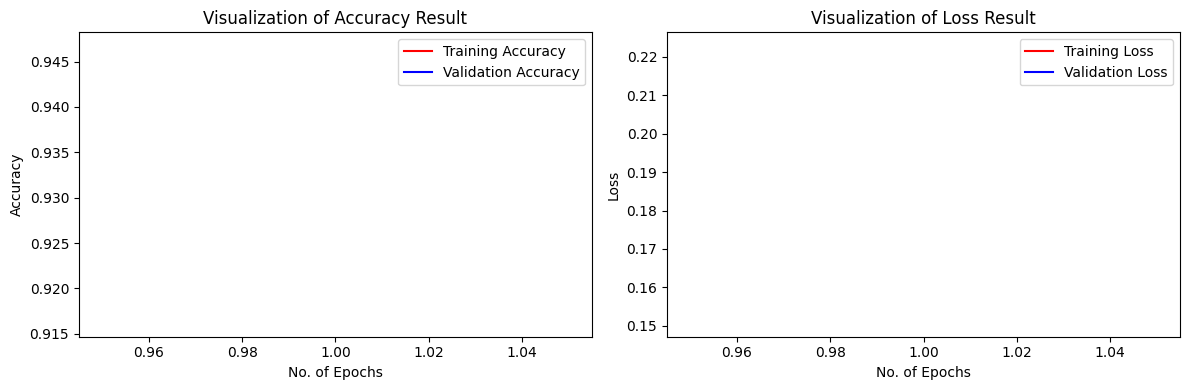

Training curves displayed as per guide specifications


In [20]:
# Visualize training results as per guide
def visualize_training_results(training_history):
    """
    Visualize training results as per guide
    """
    print("Visualizing training results...")
    
    # Check if we have any training history
    if len(training_history.history['accuracy']) == 0:
        print("No training history available (0 epochs run)")
        print("Skipping visualization - run with epochs > 0 to see training curves")
        return
    
    epochs = range(1, len(training_history.history['accuracy']) + 1)
    
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
    plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Visualization of Accuracy Result')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_history.history['loss'], color='red', label='Training Loss')
    plt.plot(epochs, training_history.history['val_loss'], color='blue', label='Validation Loss')
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.title('Visualization of Loss Result')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Training curves displayed as per guide specifications")

# Visualize training results
visualize_training_results(training_history)

Evaluating model as per guide...
Training accuracy: 0.9523 (95.23%)
Validation accuracy: 0.9162 (91.62%)
6/6 [==============================] - 4s 638ms/step

Classification Report (as per guide)
              precision    recall  f1-score   support

     Healthy       0.95      0.88      0.92        92
     Disease       0.88      0.95      0.92        87

    accuracy                           0.92       179
   macro avg       0.92      0.92      0.92       179
weighted avg       0.92      0.92      0.92       179



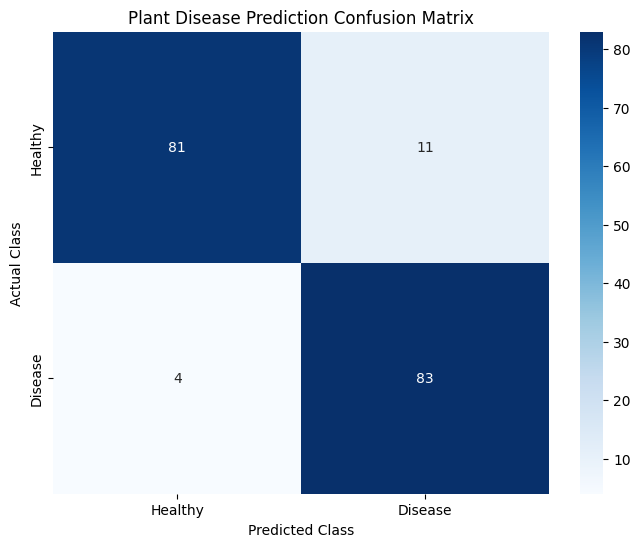

Confusion matrix displayed as per guide specifications


In [21]:
# Model evaluation as per guide specifications
def evaluate_model(cnn, X_train, y_train, X_val, y_val, classes):
    """
    Model evaluation as per guide specifications
    """
    print("Evaluating model as per guide...")
    
    # Evaluate on training set as per guide
    train_loss, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
    print(f'Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)')
    
    # Evaluate on validation set as per guide
    val_loss, val_acc = cnn.evaluate(X_val, y_val, verbose=0)
    print(f'Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)')
    
    # Prediction on validation set as per guide
    y_pred = cnn.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_val, axis=1)
    
    # Classification report as per guide
    print("\nClassification Report (as per guide)")
    print(classification_report(
        y_true_labels, y_pred_labels,
        target_names=classes
    ))
    
    # Confusion matrix as per guide
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Plant Disease Prediction Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Confusion matrix displayed as per guide specifications")
    
    return train_acc, val_acc

# Evaluate the model
train_acc, val_acc = evaluate_model(cnn, X_train, y_train, X_val, y_val, classes)

Testing single image prediction...


1/1 [==============================] - 0s 220ms/step
Sample prediction test
Image: Dataset\Healthy\800edef467d27c15.jpg
Predicted class: Healthy
Confidence: 0.7962


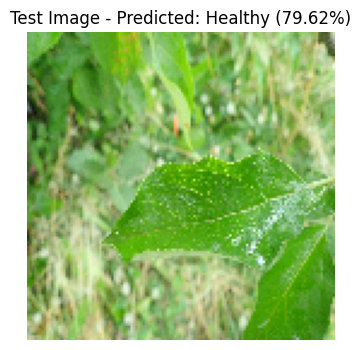

Sample prediction saved to models\sample_prediction.png

TRAINING COMPLETE - Following Guide Specifications
Model Architecture: Custom CNN (5 blocks + Dense layers)
Image Size: (128, 128)
Classes: 2 (Healthy, Disease)
Training Accuracy: 0.9523 (95.23%)
Validation Accuracy: 0.9162 (91.62%)
Model saved: models\plant_disease_model_20250801_010540_img128x128_batch32_epochs1_lr0.0001.keras
History saved: models\training_history_20250801_010540.json
Results saved in: models/

Ready for deployment!


In [22]:
# Test single prediction as per guide
def test_single_prediction(cnn, paths, classes):
    """
    Test prediction on single image as per guide
    """
    print("Testing single image prediction...")
    
    def predict_single_image(image_path):
        """
        Predict on single image as per guide specifications
        """
        # Load and preprocess image
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = np.array([input_arr])  # Convert to batch
        
        # Normalize as per guide
        input_arr = input_arr / 255.0
        
        # Make prediction
        predictions = cnn.predict(input_arr)
        result_index = np.argmax(predictions)
        predicted_class = classes[result_index]
        confidence = predictions[0][result_index]
        
        return predicted_class, confidence
    
    # Test with a sample image
    sample_image_path = paths[0]  # Use first image as test
    predicted_class, confidence = predict_single_image(sample_image_path)
    
    print(f"Sample prediction test")
    print(f"Image: {sample_image_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    
    # Display the test image
    plt.figure(figsize=(6, 4))
    img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.title(f'Test Image - Predicted: {predicted_class} ({confidence:.2%})')
    plt.axis('off')
    plt.savefig(os.path.join(MODEL_DIR, 'sample_prediction.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Sample prediction saved to {os.path.join(MODEL_DIR, 'sample_prediction.png')}")

# Test single prediction
test_single_prediction(cnn, paths, classes)

# Final summary
print("\n" + "=" * 80)
print("TRAINING COMPLETE - Following Guide Specifications")
print("=" * 80)
print(f"Model Architecture: Custom CNN (5 blocks + Dense layers)")
print(f"Image Size: {IMG_SIZE}")
print(f"Classes: {len(classes)} ({', '.join(classes)})")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Model saved: {MODEL_PATH}")
print(f"History saved: {HISTORY_PATH}")
print(f"Results saved in: {MODEL_DIR}/")
print("\nReady for deployment!")
print("=" * 80)